In [56]:
import os
import re
import json

import nltk
from nltk.corpus import stopwords

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.layers import AdditiveAttention
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import urllib
import urllib.request
from bs4 import BeautifulSoup 
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

import summa
from summa.summarizer import summarize

# Step 1. 데이터 수집하기

In [6]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [7]:
data_org = data.copy()

In [64]:
data = data_org.copy()

# Step 2. 데이터 전처리하기 (추상적 요약)

실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 보세요. 만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해 보세요.

# clean data

In [9]:
def remove_duplicates(df):
    df.drop_duplicates(subset=['headlines'], inplace=True)
    df.drop_duplicates(subset=['text'], inplace=True)
    return df

In [66]:
data = remove_duplicates(data)

In [65]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [17]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens


In [21]:
# 전체 Headlines 데이터에 대한 전처리
clean_headlines = []

for text in data['headlines']:
    clean_headlines.append(preprocess_sentence(text))

/var/folders/r0/w084nh2s0v3fstg3n70027500000gn/T/ipykernel_37059/1434855924.py:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거


headlines 전처리 후 결과:  ['upgrad learner switches career ml al salary hike', 'delhi techie wins free food swiggy one year cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'known hirani yrs metoo claims true sonam']


In [22]:
# 전체 Text 데이터에 대한 전처리
clean_text = []

for text in data['text']:
    clean_text.append(preprocess_sentence(text))

text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

## json

In [31]:
with open('clean_text.json', 'w') as file:
    json.dump(clean_text, file)

with open('clean_headlines.json', 'w') as file:
    json.dump(clean_headlines, file)

In [4]:
with open('clean_text.json', 'r') as file:
    loaded_text = json.load(file)

with open('clean_headlines.json', 'r') as file:
    loaded_headlines = json.load(file)

In [68]:
# data['headlines'] = clean_headlines
# data['text'] = clean_text

In [ ]:
data['headlines_original'] = data['headlines']
data['text_original'] = data['text']

In [115]:
data['headlines'] = loaded_headlines
data['text'] = loaded_text

In [116]:
# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

## sample length

In [217]:
# 길이 분포 출력
text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('헤드라인의 최소 길이 : {}'.format(np.min(headlines_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headlines_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(headlines_len)))

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.10029309397326
헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 13
헤드라인의 평균 길이 : 7.136787364393153


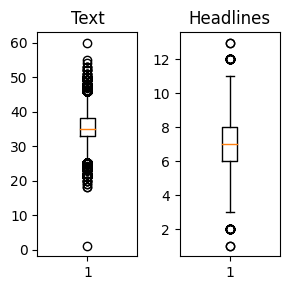

In [119]:
plt.figure(figsize=(3, 3))
plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('Headlines')
plt.tight_layout()
plt.show()

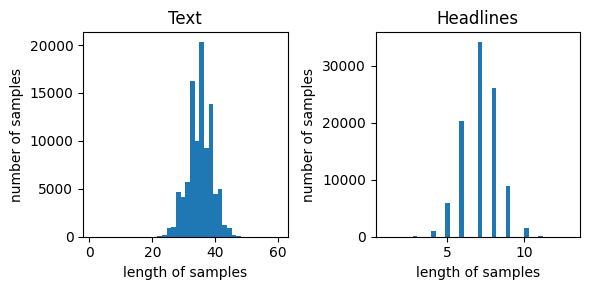

In [120]:
plt.figure(figsize=(6, 3))
plt.subplot(1,2,1)
plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.subplot(1,2,2)
plt.title('Headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.tight_layout()
plt.show()

In [127]:
text_max_len = 50
headlines_max_len = 10

In [220]:
def print_threshold_ratio(max_len, data_len):
    total = len(data_len)
    under_threshold = len([i for i in data_len if i <= max_len])
    over_threshold = len([i for i in data_len if i > max_len])
    print('under-threshold data: ', under_threshold)
    print('over-threshold data: ', over_threshold)
    print('threshold ratio: %.2f' % (under_threshold / total))

In [222]:
print('text:')
print_threshold_ratio(text_max_len, text_len)
print('headlines:')
print_threshold_ratio(headlines_max_len, headlines_len)

text:
under-threshold data:  98248
over-threshold data:  14
threshold ratio: 1.00
headlines:
under-threshold data:  98049
over-threshold data:  213
threshold ratio: 1.00


In [226]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]

## SOS, EOS

In [229]:
data.loc[:, 'decoder_input'] = data['headlines'].apply(lambda x : 'sostoken ' + x)
data.loc[:, 'decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')

In [231]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블
text_original = np.array(data['text_original'])  # 원본 텍스트 레이블

In [232]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)

In [233]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
text_original = text_original[indices]

In [234]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19607


In [265]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]
text_original_train = text_original[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]
text_original_test = text_original[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78429
훈련 레이블의 개수 : 78429
테스트 데이터의 개수 : 19607
테스트 레이블의 개수 : 19607


## integer encoding

In [239]:
def print_word_frequency(input_train, threshold_value=0):
    
    tokenizer = Tokenizer() # 토크나이저 정의
    tokenizer.fit_on_texts(input_train) # 입력된 데이터로부터 단어 집합 생성
    
    threshold = threshold_value
    total_cnt = len(tokenizer.word_index) # 단어의 수
    rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
    total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
    rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

    # 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
    for key, value in tokenizer.word_counts.items():
        total_freq = total_freq + value

        # 단어의 등장 빈도수가 threshold보다 작으면
        if(value < threshold):
            rare_cnt = rare_cnt + 1
            rare_freq = rare_freq + value

    print('단어 집합(vocabulary)의 크기 :', total_cnt)
    print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
    print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
    print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
    print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)


In [269]:
# 인코더 단어 빈도
print_word_frequency(encoder_input_train, threshold_value=50)

단어 집합(vocabulary)의 크기 : 69625
등장 빈도가 49번 이하인 희귀 단어의 수: 62492
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 7133
단어 집합에서 희귀 단어의 비율: 89.75511669658887
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 13.61233768357701


In [270]:
src_vocab = 7000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [271]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

In [275]:
# 디코더 단어 빈도
print_word_frequency(decoder_input_train, threshold_value=50)

단어 집합(vocabulary)의 크기 : 29879
등장 빈도가 49번 이하인 희귀 단어의 수: 27639
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 2240
단어 집합에서 희귀 단어의 비율: 92.50309581980656
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 27.109173648486482


In [276]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

In [277]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

In [278]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

삭제할 훈련 데이터의 개수 : 250
삭제할 테스트 데이터의 개수 : 57


In [192]:
def drop_onesentence(data, drop_data):
    return [sentence for index, sentence in enumerate(data) if index not in drop_data]

In [279]:
encoder_input_train = drop_onesentence(encoder_input_train, drop_train)
decoder_input_train = drop_onesentence(decoder_input_train, drop_train)
decoder_target_train = drop_onesentence(decoder_target_train, drop_train)

encoder_input_test = drop_onesentence(encoder_input_test, drop_test)
decoder_input_test = drop_onesentence(decoder_input_test, drop_test)
decoder_target_test = drop_onesentence(decoder_target_test, drop_test)

In [280]:
print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78179
훈련 레이블의 개수 : 78179
테스트 데이터의 개수 : 19550
테스트 레이블의 개수 : 19550


In [281]:
text_original_train = drop_onesentence(text_original_train, drop_train)
text_original_test = drop_onesentence(text_original_test, drop_test)

In [282]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

## encoder, decoder

In [290]:
# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_outputs, state_h3, state_c3 = encoder_lstm3(encoder_output2)


In [291]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h3, state_c3])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

In [292]:
# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_23 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 embedding_10 (Embedding)    (None, 50, 128)              896000    ['input_23[0][0]']            
                                                                                                  
 lstm_20 (LSTM)              [(None, 50, 256),            394240    ['embedding_10[0][0]']        
                              (None, 256),                                                        
                              (None, 256)]                                                        
                                                                                           

# Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)

일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있어요. 실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계해 보세요.


In [293]:
# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_23 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 embedding_10 (Embedding)    (None, 50, 128)              896000    ['input_23[0][0]']            
                                                                                                  
 lstm_20 (LSTM)              [(None, 50, 256),            394240    ['embedding_10[0][0]']        
                              (None, 256),                                                        
                              (None, 256)]                                                        
                                                                                           

In [294]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=2)

Epoch 1/2


2023-07-17 23:51:11.981532: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" frequency: 2400 num_cores: 8 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 524288 l3_cache_size: 524288 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


306/306 [==============================] - ETA: 0s - loss: 3.6155

2023-07-17 23:54:27.250748: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" frequency: 2400 num_cores: 8 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 524288 l3_cache_size: 524288 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


306/306 [==============================] - 215s 695ms/step - loss: 3.6155 - val_loss: 3.3528
Epoch 2/2
306/306 [==============================] - 212s 693ms/step - loss: 3.1849 - val_loss: 3.0479


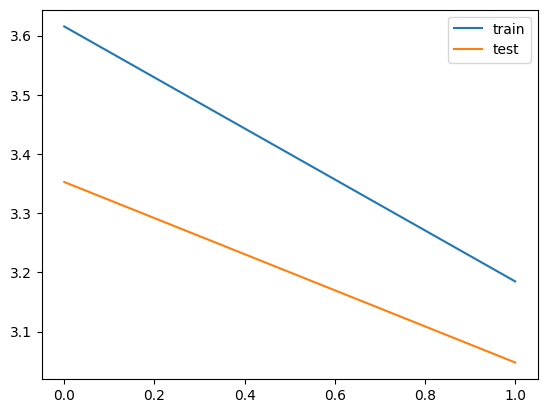

In [295]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)

원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해 보세요.


In [296]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [299]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h3, state_c3])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [300]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])


In [301]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence


In [302]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2headlines(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [303]:
for i in range(0, 1):
    text = seq2text(encoder_input_test[i])
    print("- 토큰화된 원문: \n{}\n".format(text))
    print("- 실제 요약: \n{}\n".format(seq2headlines(decoder_input_test[i])))
    print("\n- 예측 요약: \n{}\n".format(decode_sequence(encoder_input_test[i].reshape(1, text_max_len))))
    print("- 원문: \n{}\n".format(text_original_test[i]))
    print("- 'SUMMARIZE' 요약: \n{}\n".format(summarize(text_original_test[i], ratio=0.4)))

- 토큰화된 원문: 
india fourth valuable services firm wipro friday announced would buy us based solutions india operations million solutions provides cloud based hr financial solutions clients company five offices india across four locations chennai mumbai noida gurugram employees 

- 실제 요약: 
buy us based india operations cr 

1/1 [==============================] - 0s 7ms/step

- 예측 요약: 
 india india

- 원문: 
India's fourth most valuable IT services firm Wipro on Friday announced it would buy US-based Alight Solutions' India operations for $117 million (Ã¢ÂÂ¹804 crore). Alight Solutions provides cloud-based HR and financial solutions to 1,400 clients. The company has five offices in India across four locations Ã¢ÂÂ Chennai, Mumbai, Noida, and Gurugram, and has over 9,000 employees.

- 'SUMMARIZE' 요약: 
India's fourth most valuable IT services firm Wipro on Friday announced it would buy US-based Alight Solutions' India operations for $117 million (Ã¢ÂÂ¹804 crore).



2023-07-17 23:59:29.029240: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" frequency: 2400 num_cores: 8 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 524288 l3_cache_size: 524288 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


# Step 5. Summa을 이용해서 추출적 요약해보기

추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높아요. 반대로 말하면 추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮아요.

Summa의 summarize를 사용하여 추출적 요약을 해보세요.

In [78]:
data_org['text'].iloc[0]

"Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers."

In [85]:
print(summarize(data_org['text'].iloc[0], ratio=0.4))

upGrad's Online Power Learning has powered 3 lakh+ careers.


In [87]:
print(summarize(data_org['text'].iloc[0], words=20))

The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike.
upGrad's Online Power Learning has powered 3 lakh+ careers.
